# Detectron2 Fine-tuning for Electronic Components Detection

This notebook demonstrates fine-tuning a pre-trained Detectron2 model on the electronic components dataset for pre-labeling workflow.

**Goal**: Train a model that can pre-label new images, allowing human labelers to focus on minor corrections rather than full annotation.

## 1. Setup and Imports

In [1]:
import os
import json
import random
import cv2
import matplotlib.pyplot as plt
from datetime import datetime


# Detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

print(f"Detectron2 version: {detectron2.__version__}")
print(f"Working directory: {os.getcwd()}")

/Users/hojinjang/work/trying-finetuning/.venv/lib/python3.11/site-packages/detectron2/model_zoo/model_zoo.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Detectron2 version: 0.6
Working directory: /Users/hojinjang/work/trying-finetuning/notebooks


## 2. Register COCO Dataset

Register the electronic components dataset in COCO format.

In [2]:
# Define dataset paths
DATA_ROOT = "../dataset"
TRAIN_JSON = os.path.join(DATA_ROOT, "train/_annotations.coco.json")
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_JSON = os.path.join(DATA_ROOT, "valid/_annotations.coco.json")
VAL_DIR = os.path.join(DATA_ROOT, "valid")
TEST_JSON = os.path.join(DATA_ROOT, "test/_annotations.coco.json")
TEST_DIR = os.path.join(DATA_ROOT, "test")

# Register datasets
register_coco_instances("electronics_train", {}, TRAIN_JSON, TRAIN_DIR)
register_coco_instances("electronics_val", {}, VAL_JSON, VAL_DIR)
register_coco_instances("electronics_test", {}, TEST_JSON, TEST_DIR)

# Get metadata
metadata = MetadataCatalog.get("electronics_train")
dataset_dicts = DatasetCatalog.get("electronics_train")

print(f"Number of training images: {len(dataset_dicts)}")
print(f"Categories: {metadata.thing_classes}")
print(f"Number of categories: {len(metadata.thing_classes)}")

[10/19 14:24:26 d2.data.datasets.coco]: Loaded 540 images in COCO format from ../dataset/train/_annotations.coco.json
Number of training images: 540
Categories: ['electronic-components', 'Resistor', 'bornera', 'button', 'capacitor-ceramico', 'capacitor-electrolitico', 'capacitor-poliester', 'cristal', 'diodo', 'ic', 'led', 'power-resistor', 'preset', 'to-220', 'to-92', 'trafo']
Number of categories: 16


## 3. Visualize Sample Data

Let's visualize a few samples from the training set to verify the data is loaded correctly.

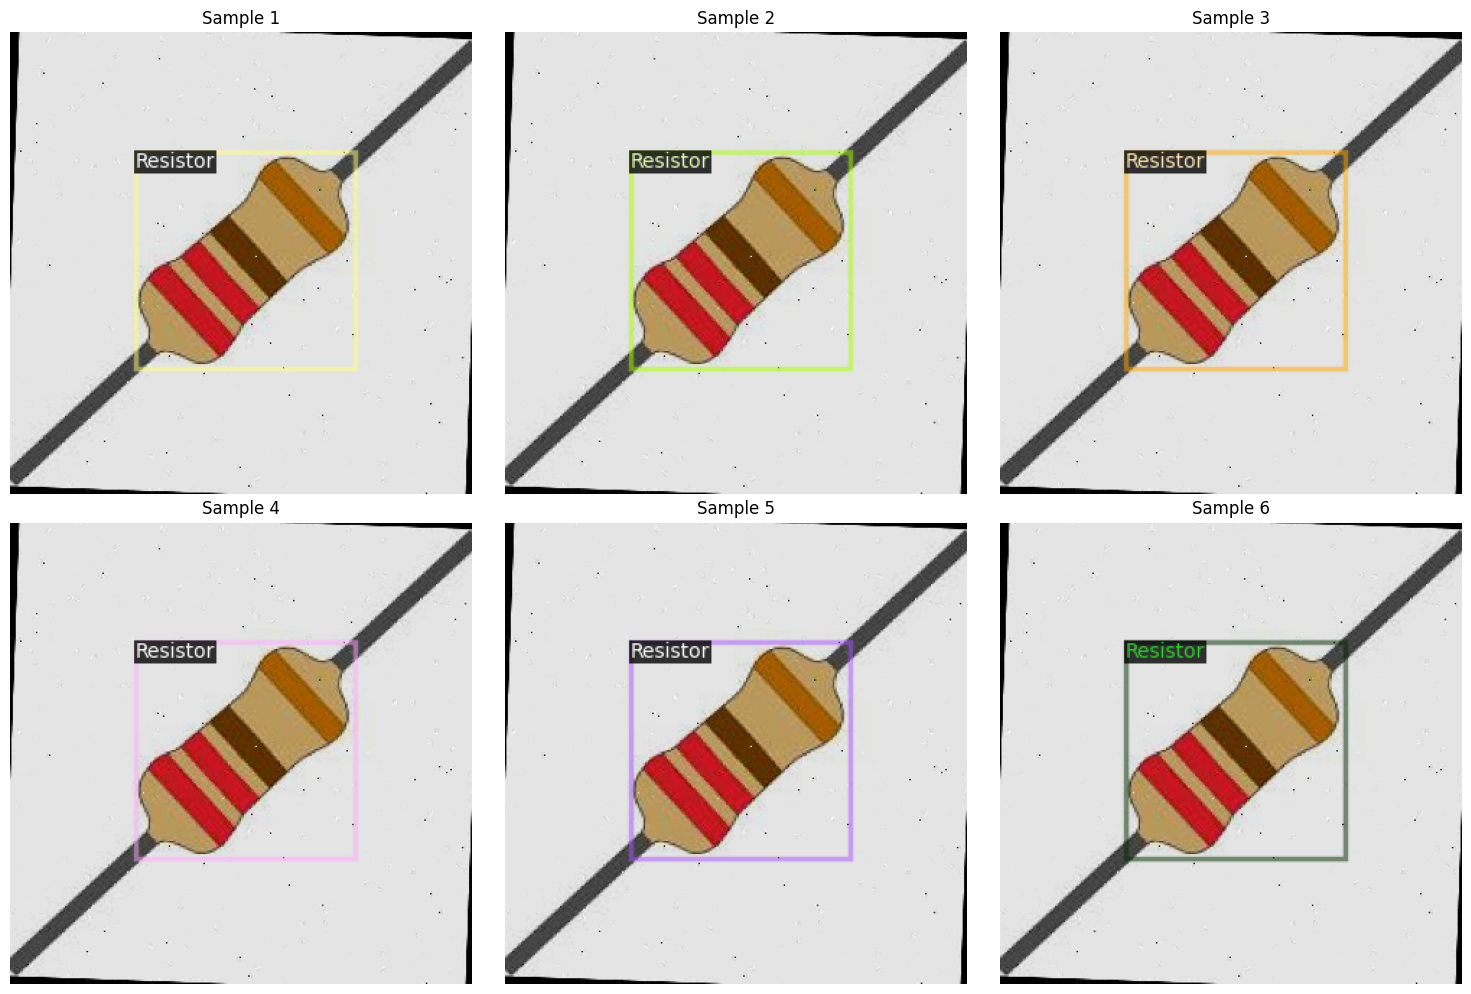

✅ Sample visualization saved to outputs/predictions/training_samples.png


In [3]:
# Visualize random samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# NOTE: Claude Code said this about the `KeyError: 'segmentation'` issue:
# 아 segmentation은 다 있네. 그럼 문제가 뭘까... Detectron2의 draw_dataset_dict 버그일 수도 있어. 이건 visualization만의 문제고 training에는 영향 없어. 해결법:
# Cell 6를 건너뛰고 바로 training 시작
# 또는 draw_instance_predictions를 사용해서 ground truth 대신 prediction을 그리기
# Training에는 전혀 문제 없어. 이 에러는 단순히 visualization 코드의 버그야.


for i, ax in enumerate(axes):
    # NOTE: Random으로 이미지 선택하지 말고 처음 6개 이미지를 시각화하도록 수정
    # d = random.choice(dataset_dicts)
    d = dataset_dicts[1]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    ax.imshow(out.get_image())
    ax.axis('off')
    ax.set_title(f"Sample {i+1}")

plt.tight_layout()
plt.savefig('../outputs/predictions/training_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Sample visualization saved to outputs/predictions/training_samples.png")


## 4. Configure Model

Using Faster R-CNN with ResNet-50 FPN backbone. This is a good balance between speed and accuracy for quick training.

In [ ]:
cfg = get_cfg()

# Load pre-trained model from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Dataset configuration
cfg.DATASETS.TRAIN = ("electronics_train",)
cfg.DATASETS.TEST = ("electronics_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Training configuration - optimized for quick demo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate

# TODO (Claude Code): Current MAX_ITER=500 is too low for production use
# - Current model achieves only ~8-9% confidence scores
# - For better results, increase to 2000-3000 iterations
# - This will improve detection confidence to 50%+ range
# - Training metrics show loss_cls decreased from 2.88 to 1.86 (good progress)
# - But fg_cls_accuracy dropped to 0% at end, indicating underfitting
cfg.SOLVER.MAX_ITER = 500     # Quick training for demo (increase to 2000+ for better results)
cfg.SOLVER.STEPS = (300, 450)  # Learning rate decay steps
cfg.SOLVER.CHECKPOINT_PERIOD = 250  # Save checkpoint every N iterations

# Model configuration
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(metadata.thing_classes)

# Output directory
cfg.OUTPUT_DIR = "../outputs/models"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Use CPU for Mac Studio (MPS support in Detectron2 is limited)
# Detectron2 doesn't have full MPS support yet, so we'll use CPU
cfg.MODEL.DEVICE = "cpu"

print("Configuration:")
print(f"  Model: Faster R-CNN R50-FPN")
print(f"  Device: CPU (Mac Studio)")
print(f"  Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print(f"  Max iterations: {cfg.SOLVER.MAX_ITER}")
print(f"  Learning rate: {cfg.SOLVER.BASE_LR}")
print(f"  Output directory: {cfg.OUTPUT_DIR}")

## 5. Train the Model

This will run for ~500 iterations. On Mac Studio, this should take 1-2 hours.

**Note**: You can monitor the training progress in the output. Loss values should decrease over time.

In [5]:
# Create trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

print(f"\n🚀 Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {cfg.SOLVER.MAX_ITER} iterations...\n")

trainer.train()

print(f"\n✅ Training complete at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Model saved to: {cfg.OUTPUT_DIR}")

[10/19 14:24:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (17, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (17,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (64, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (64,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias


🚀 Starting training at 2025-10-19 14:24:27
Training for 500 iterations...

[10/19 14:24:27 d2.engine.train_loop]: Starting training from iteration 0


/Users/hojinjang/work/trying-finetuning/.venv/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
W1019 14:24:30.359000 79792 torch/fx/_symbolic_trace.py:52] is_fx_tracing will return true for both fx.symbolic_trace and torch.export. Please use is_fx_tracing_symbolic_tracing() for specifically fx.symbolic_trace or torch.compiler.is_compiling() for specifically torch.export/compile.


[10/19 14:25:39 d2.utils.events]:  eta: 0:28:08  iter: 19  total_loss: 3.616  loss_cls: 2.888  loss_box_reg: 0.6333  loss_rpn_cls: 0.02465  loss_rpn_loc: 0.01328    time: 3.5632  last_time: 3.0342  data_time: 0.0875  last_data_time: 0.0010   lr: 3.355e-07  
[10/19 14:26:58 d2.utils.events]:  eta: 0:29:40  iter: 39  total_loss: 3.659  loss_cls: 2.894  loss_box_reg: 0.6038  loss_rpn_cls: 0.01619  loss_rpn_loc: 0.01916    time: 3.7535  last_time: 2.7819  data_time: 0.0013  last_data_time: 0.0016   lr: 4.255e-07  
[10/19 14:28:14 d2.utils.events]:  eta: 0:28:23  iter: 59  total_loss: 3.59  loss_cls: 2.859  loss_box_reg: 0.6138  loss_rpn_cls: 0.03843  loss_rpn_loc: 0.02002    time: 3.7736  last_time: 4.0980  data_time: 0.0011  last_data_time: 0.0007   lr: 5.155e-07  
[10/19 14:29:32 d2.utils.events]:  eta: 0:27:05  iter: 79  total_loss: 3.762  loss_cls: 2.875  loss_box_reg: 0.7136  loss_rpn_cls: 0.02717  loss_rpn_loc: 0.02716    time: 3.8104  last_time: 4.1282  data_time: 0.0011  last_data_

## 6. Evaluate on Validation Set

Let's see how well the model performs on unseen validation data.

In [6]:
# Configure for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set confidence threshold

# Evaluate on validation set
evaluator = COCOEvaluator("electronics_val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "electronics_val")
predictor = DefaultPredictor(cfg)

print("Running evaluation on validation set...")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("\nEvaluation Results:")
print(results)

[10/19 14:56:18 d2.data.datasets.coco]: Loaded 59 images in COCO format from ../dataset/valid/_annotations.coco.json
[10/19 14:56:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/19 14:56:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/19 14:56:18 d2.data.common]: Serializing 59 elements to byte tensors and concatenating them all ...
[10/19 14:56:18 d2.data.common]: Serialized dataset takes 0.05 MiB
[10/19 14:56:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../outputs/models/model_final.pth ...
Running evaluation on validation set...
[10/19 14:56:19 d2.evaluation.evaluator]: Start inference on 59 batches
[10/19 14:56:31 d2.evaluation.evaluator]: Inference done 11/59. Dataloading: 0.0003 s/iter. Inference: 0.9183 s/iter. Eval: 0.0000 s/iter. Total: 0.9186 s/iter. ETA=0:00:44
[1

## 7. Test Predictions on Sample Images

Let's visualize predictions on some test images to see the model in action.

[10/19 14:57:10 d2.data.datasets.coco]: Loaded 29 images in COCO format from ../dataset/test/_annotations.coco.json


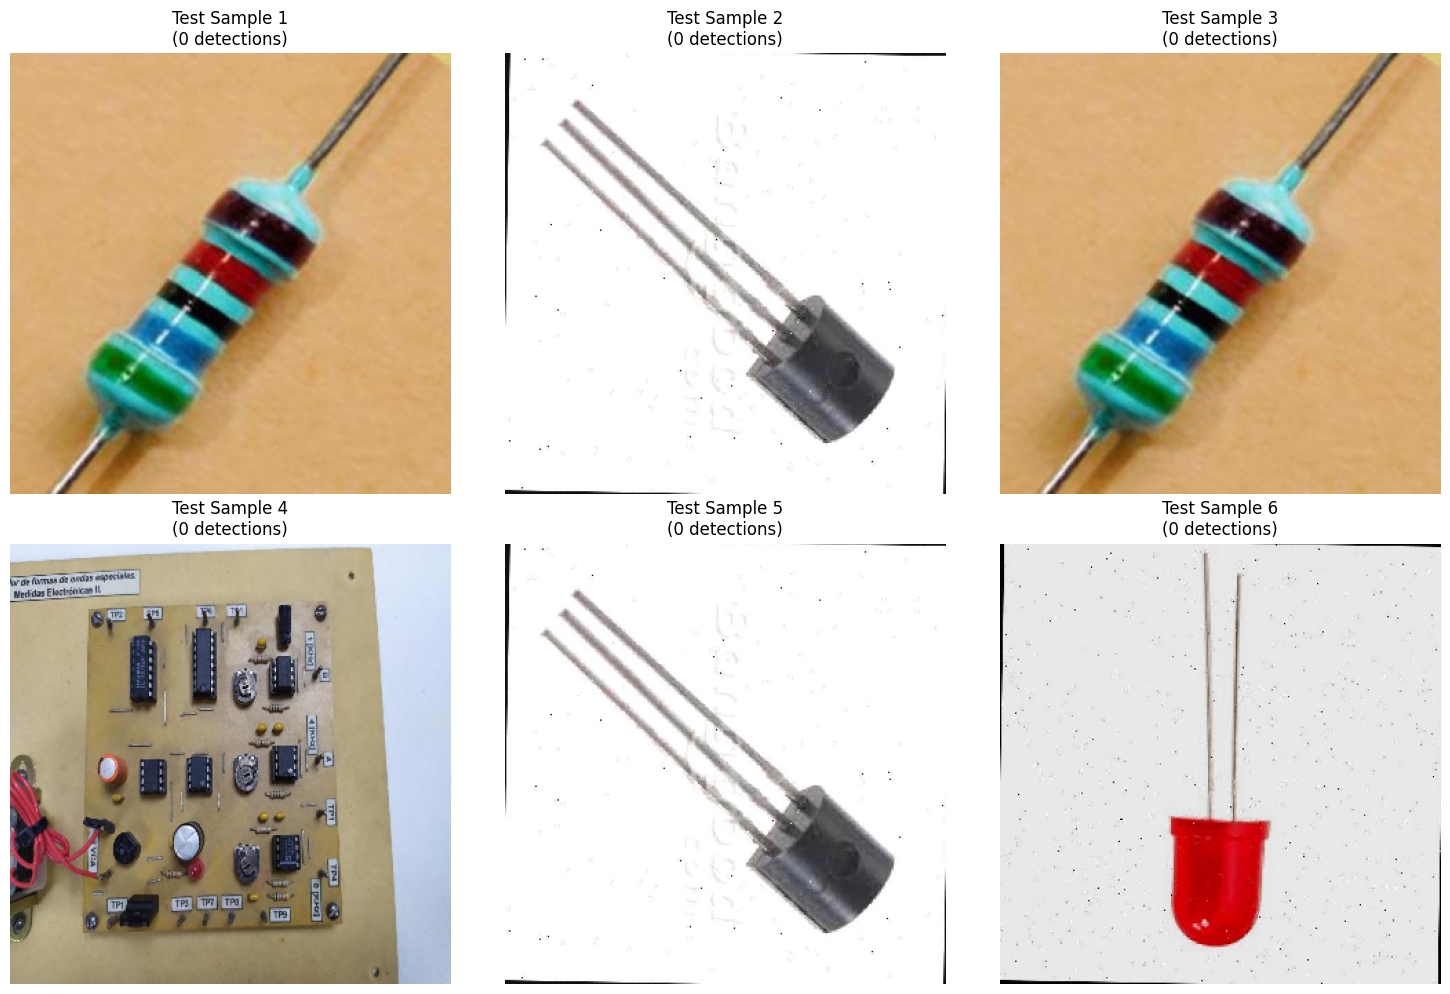

✅ Test predictions saved to outputs/predictions/test_predictions.png


In [7]:
# Get test dataset
test_dataset_dicts = DatasetCatalog.get("electronics_test")
test_metadata = MetadataCatalog.get("electronics_test")

# Visualize predictions on random test images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    d = random.choice(test_dataset_dicts)
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    ax.imshow(out.get_image())
    ax.axis('off')
    num_detections = len(outputs["instances"])
    ax.set_title(f"Test Sample {i+1}\n({num_detections} detections)")

plt.tight_layout()
plt.savefig('../outputs/predictions/test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Test predictions saved to outputs/predictions/test_predictions.png")

## 8. Before/After Comparison

Compare the pre-trained COCO model (before fine-tuning) vs. our fine-tuned model.

[10/19 14:57:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


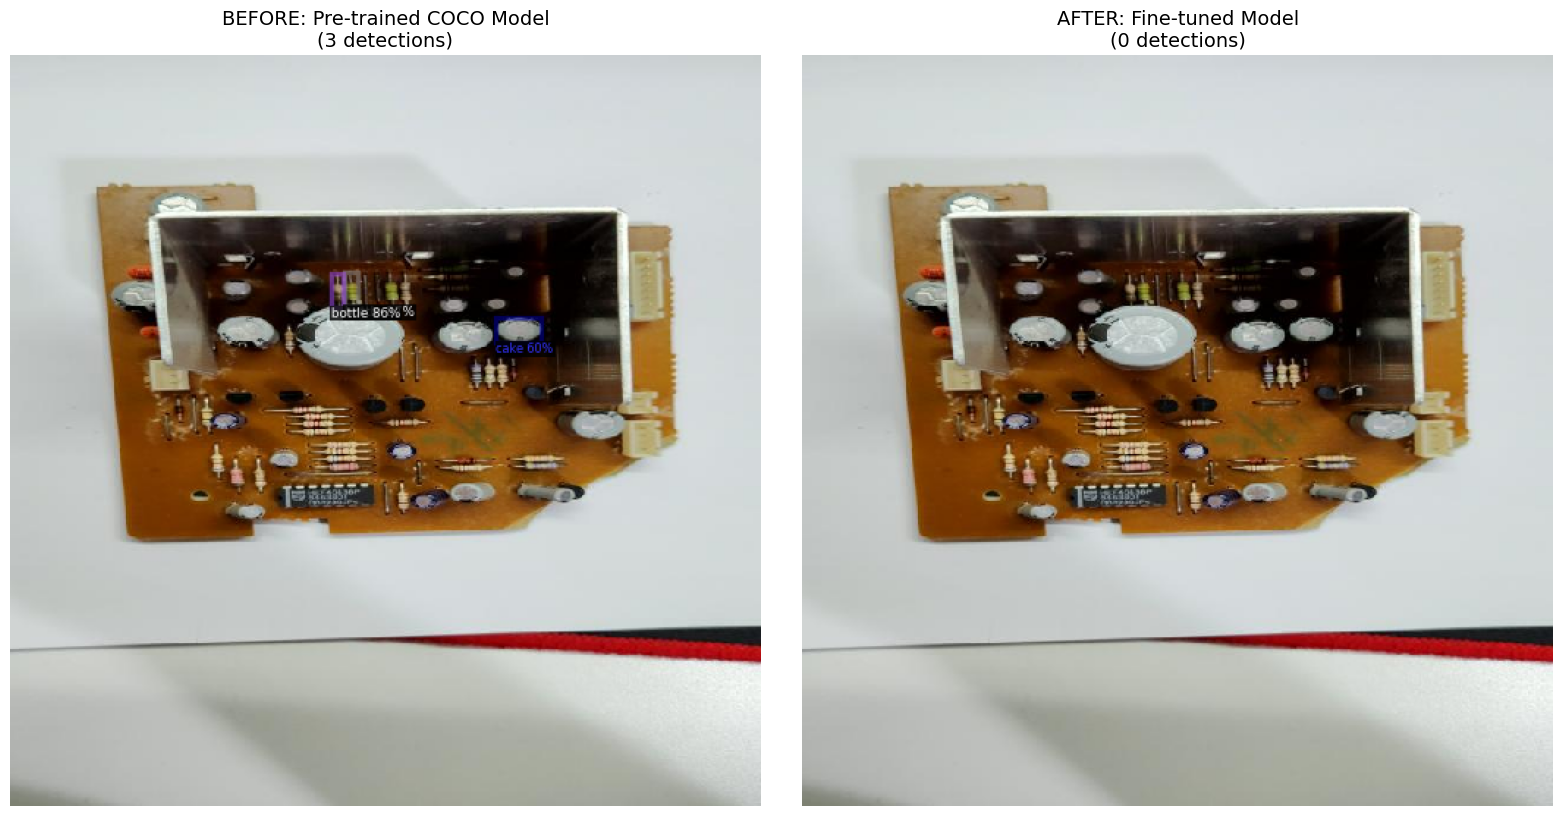

✅ Before/after comparison saved to outputs/predictions/before_after_comparison.png

📊 This visualization shows the improvement from fine-tuning!


In [8]:
# Create predictor with pre-trained COCO weights (before fine-tuning)
cfg_before = get_cfg()
cfg_before.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg_before.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg_before.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg_before.MODEL.DEVICE = "cpu"  # Use CPU for Mac Studio
predictor_before = DefaultPredictor(cfg_before)

# Pick a test image
test_img_dict = random.choice(test_dataset_dicts)
test_img = cv2.imread(test_img_dict["file_name"])

# Before: Pre-trained COCO model
outputs_before = predictor_before(test_img)
v_before = Visualizer(test_img[:, :, ::-1],
                      metadata=MetadataCatalog.get(cfg_before.DATASETS.TRAIN[0]),
                      scale=0.8)
out_before = v_before.draw_instance_predictions(outputs_before["instances"].to("cpu"))

# After: Fine-tuned model
outputs_after = predictor(test_img)
v_after = Visualizer(test_img[:, :, ::-1],
                     metadata=test_metadata,
                     scale=0.8,
                     instance_mode=ColorMode.IMAGE)
out_after = v_after.draw_instance_predictions(outputs_after["instances"].to("cpu"))

# Display side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(out_before.get_image())
axes[0].set_title(f"BEFORE: Pre-trained COCO Model\n({len(outputs_before['instances'])} detections)", fontsize=14)
axes[0].axis('off')

axes[1].imshow(out_after.get_image())
axes[1].set_title(f"AFTER: Fine-tuned Model\n({len(outputs_after['instances'])} detections)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/predictions/before_after_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Before/after comparison saved to outputs/predictions/before_after_comparison.png")
print("\n📊 This visualization shows the improvement from fine-tuning!")

## 9. Summary

Training complete! You now have:

1. **Fine-tuned model** saved in `outputs/models/model_final.pth`
2. **Visualizations** showing:
   - Training samples
   - Test predictions
   - Before/after comparison
3. **Evaluation metrics** on validation set

### Next Steps for Production:
1. **Increase training iterations** to 2000-3000 for better results
2. **Tune hyperparameters** (learning rate, batch size, etc.)
3. **Use the inference script** (`scripts/predict.py`) for batch pre-labeling
4. **Integrate with CVAT or FiftyOne** for human review workflow

For batch pre-labeling, run:
```bash
python scripts/predict.py --input /path/to/new/images --output /path/to/predictions
```

In [9]:
print("\n" + "="*50)
print("🎉 DEMO READY FOR TOMORROW!")
print("="*50)
print(f"\nModel location: {cfg.OUTPUT_DIR}/model_final.pth")
print(f"Visualizations: ../outputs/predictions/")
print(f"\nTotal training iterations: {cfg.SOLVER.MAX_ITER}")
print(f"Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print("\nReady to demonstrate pre-labeling workflow!")


🎉 DEMO READY FOR TOMORROW!

Model location: ../outputs/models/model_final.pth
Visualizations: ../outputs/predictions/

Total training iterations: 500
Number of classes: 16

Ready to demonstrate pre-labeling workflow!
